In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred = pd.read_csv('output/only_matching.csv')
orig = pd.read_parquet('sample_val.parquet')
val_Y = pd.read_parquet('val_Y.parquet')

In [322]:
pred_cols = [col for col in pred.columns if col.startswith('call_') or col.startswith('put_')]
call_cols = [col for col in pred_cols if col.startswith('call_')]
put_cols = [col for col in pred_cols if col.startswith('put_')]

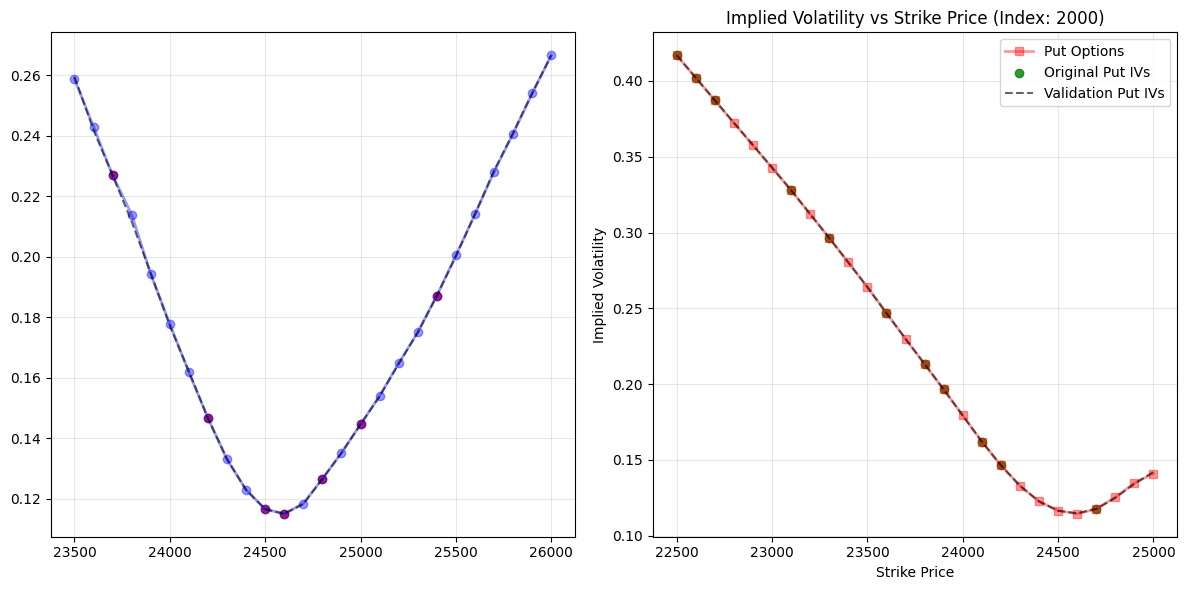

In [323]:
# Select a fixed index (e.g., index 0)
fixed_index = 2000


# Extract strike prices from column names
call_strikes = [int(col.split('_')[-1]) for col in call_cols]
put_strikes = [int(col.split('_')[-1]) for col in put_cols]

# Get IV values for the fixed index
call_ivs = pred.iloc[fixed_index][call_cols].values
put_ivs = pred.iloc[fixed_index][put_cols].values

# Create the plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(call_strikes, call_ivs, 'b-', marker='o', label='Call Options', linewidth=2, alpha=0.4)
plt.scatter(call_strikes, orig.iloc[fixed_index][call_cols].values, color='red', label='Original Call IVs', alpha=0.8)
plt.plot(call_strikes, val_Y.iloc[fixed_index][call_cols].values, 'k--', label='Validation Call IVs', alpha=0.6)
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(put_strikes, put_ivs, 'r-', marker='s', label='Put Options', linewidth=2, alpha=0.4)
plt.scatter(put_strikes, orig.iloc[fixed_index][put_cols].values, color='green', label='Original Put IVs', alpha=0.8)
plt.plot(put_strikes, val_Y.iloc[fixed_index][put_cols].values, 'k--', label='Validation Put IVs', alpha=0.6)

plt.grid(True, alpha=0.3)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatility vs Strike Price (Index: {fixed_index})')
plt.legend()

plt.tight_layout()
plt.show()

In [324]:
def smoothPCA(data, n_components=2):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=n_components)
    test_df_2_raw = pca.inverse_transform(pca.fit_transform(data[pred_cols]))
    test_df_2 = data.copy()
    test_df_2[pred_cols] = test_df_2_raw
    # For each call and put column, replace values in test_df_2 with non-NaN values from test_df_original
    for col in pred_cols:
        if col in orig.columns:
            # Get mask of non-NaN values in original data
            non_nan_mask = ~orig[col].isna()
            # # Replace corresponding values in test_df_2
            test_df_2.loc[non_nan_mask, col] = orig.loc[non_nan_mask, col]

    return test_df_2

In [325]:
pred.index = orig.index  # Ensure the indices match
pred_smoothed = pred.copy()
pred_smoothed = smoothPCA(pred_smoothed, n_components=5)
pred_smoothed = smoothPCA(pred_smoothed, n_components=5)
pred_smoothed = smoothPCA(pred_smoothed, n_components=5)
# pred_smoothed = smoothPCA(pred_smoothed, n_components=6)

# for i in range(20):
#     pred_smoothed = smoothPCA(pred_smoothed, n_components=8)
#     print(f'Iteration {i + 1} completed.')

In [326]:
from sklearn.metrics import root_mean_squared_error as rmse

rmse(pred_smoothed[pred_cols], val_Y[pred_cols])  # Calculate RMSE for smoothed predictions

0.000859882337706149

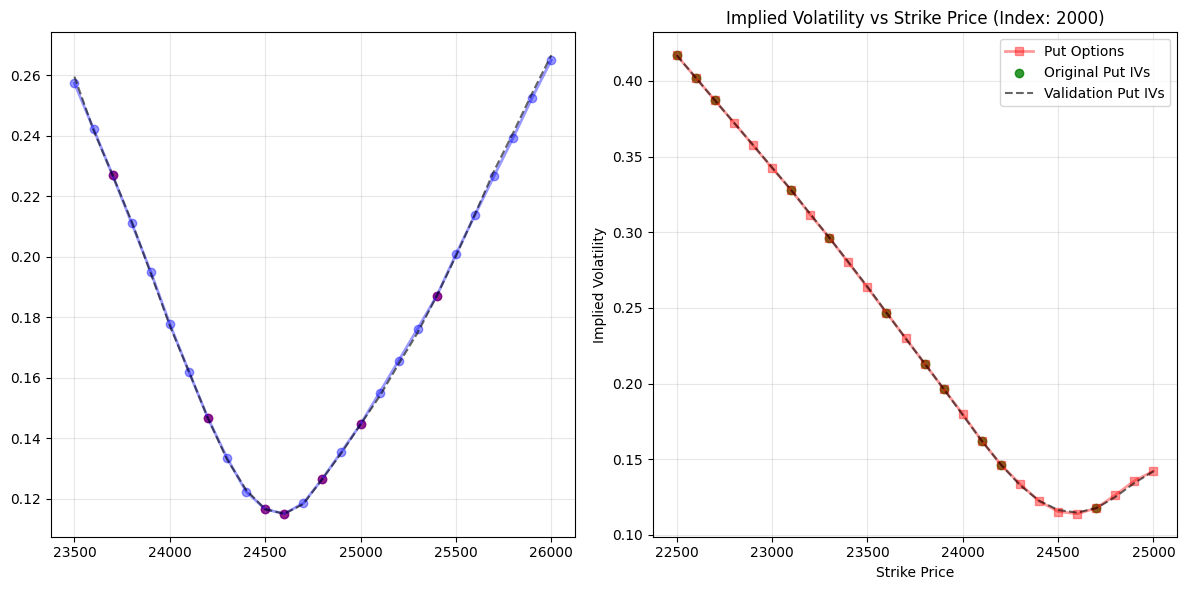

In [327]:
# Select a fixed index (e.g., index 0)
fixed_index = 2000


# Extract strike prices from column names
call_strikes = [int(col.split("_")[-1]) for col in call_cols]
put_strikes = [int(col.split("_")[-1]) for col in put_cols]

# Get IV values for the fixed index
call_ivs = pred_smoothed.iloc[fixed_index][call_cols].values
put_ivs = pred_smoothed.iloc[fixed_index][put_cols].values

# Create the plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    call_strikes,
    call_ivs,
    "b-",
    marker="o",
    label="Call Options",
    linewidth=2,
    alpha=0.4,
)
plt.scatter(
    call_strikes,
    orig.iloc[fixed_index][call_cols].values,
    color="red",
    label="Original Call IVs",
    alpha=0.8,
)
plt.plot(
    call_strikes,
    val_Y.iloc[fixed_index][call_cols].values,
    "k--",
    label="Validation Call IVs",
    alpha=0.6,
)
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(
    put_strikes, put_ivs, "r-", marker="s", label="Put Options", linewidth=2, alpha=0.4
)
plt.scatter(
    put_strikes,
    orig.iloc[fixed_index][put_cols].values,
    color="green",
    label="Original Put IVs",
    alpha=0.8,
)
plt.plot(
    put_strikes,
    val_Y.iloc[fixed_index][put_cols].values,
    "k--",
    label="Validation Put IVs",
    alpha=0.6,
)

plt.grid(True, alpha=0.3)
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title(f"Implied Volatility vs Strike Price (Index: {fixed_index})")
plt.legend()

plt.tight_layout()
plt.show()

In [328]:
from scipy.signal import savgol_filter

def savgol_smooth(df, window_length=5, polyorder=2):
    smoothed_calls = savgol_filter(
        df[call_cols], window_length=window_length, polyorder=polyorder
    )
    smoothed_puts = savgol_filter(df[put_cols], window_length=window_length, polyorder=polyorder)
    test_df_savgol = df.copy()
    test_df_savgol[call_cols] = smoothed_calls
    test_df_savgol[put_cols] = smoothed_puts

    for col in pred_cols:
        if col in orig.columns:
            # Get mask of non-NaN values in original data
            non_nan_mask = ~orig[col].isna()
            # # Replace corresponding values in test_df_2
            test_df_savgol.loc[non_nan_mask, col] = orig.loc[non_nan_mask, col]
    return test_df_savgol

In [329]:
test_df_savgoll = savgol_smooth(pred_smoothed, window_length=5, polyorder=2)


In [330]:
from sklearn.metrics import root_mean_squared_error as rmse

rmse(
    test_df_savgoll[pred_cols], val_Y[pred_cols]
)  # Calculate RMSE for smoothed predictions

0.0008293302951223857

In [333]:
test_df_savgoll.to_csv("output/savgol.csv", index=False)